<div style="float: right; width: 70%; height: 150px;">
  <div style="position: relative; top: 20%;padding-right:20%;">
  <div style="font-size:280%;font-weight: bold;padding-top: 20px;"> Exercise</div>
  <div style="font-size:180%;font-weight: bold;padding-top: 20px;color: rgba(0 , 0 , 0 , 0.5);"> Surface waves</div>
  </div>
</div>


This script will get an event from IRIS and retrieve a seismogram for a selected station. It then converts the raw trace to ground displacement. <br>

**Questions**:<br> 
**How to separate the Love and Rayleigh wave?**<br>
**How are the amplitude spectra distributed between body and surface waves?**<br> 

for more notebooks in seismology, see:<br>
https://krischer.github.io/seismo_live_build/tree/index.html

## 0. Setup

Note: this python script requires extra packages for
    - matplotlib (version 2.1.2) : > pip install -U matplotlib
    - numpy      (version 1.14.0): > pip install -U numpy
    - obspy      (version 1.1.0) : > pip install -U obspy

In [15]:
from __future__ import print_function
import os,sys

# for fixed plots
%matplotlib inline
# for interactive plots
#%matplotlib notebook

import matplotlib as mpl
print("matplotlib version: ",mpl.__version__)

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 20, 5
plt.rcParams['lines.linewidth'] = 0.5

## numpy
import numpy as np
print("numpy version: ",np.__version__)

# do not show scipy warnings
import warnings
warnings.filterwarnings('ignore')

matplotlib version:  3.1.3
numpy version:  1.18.1


uses obspy<br>
http://docs.obspy.org<br>
a python framework for seismology


In [16]:
import obspy
print("obspy version: ",obspy.__version__)


obspy version:  1.1.1




## 1. Event information

Let's look at a Mw 7.7 earthquake in the Vanuatu trench.<br>

Specify the event time.<br>

Vanuatu quake: (Magnitude Mw ~ 7.7)<br>
April 21, 1997, UTC12:02:30 -> 1997-04-21T12:02:30



In [17]:
print("getting event information...")
from obspy.clients.fdsn import Client

event_time = obspy.UTCDateTime("1997-04-21T12:02:30")

# data client
# data centers: FDSN, IRIS, ORFEUS, IPGP, ETH, GFZ, RESIF, GEONET, USGS, ..
c = Client("IRIS")  

starttime = event_time - 10 * 60
endtime = event_time + 10 * 60
Mw_min = 5.0

catalog = c.get_events(starttime=starttime, endtime=endtime, minmagnitude=Mw_min)
# or
#catalog = c.get_events(eventid=3320897)
print("Event catalog:")
print(catalog)


getting event information...
Event catalog:
3 Event(s) in Catalog:
1997-04-21T12:11:28.920000Z | -13.509, +166.553 | 6.2 mb
1997-04-21T12:06:34.760000Z | -12.852, +166.459 | 6.1 mb
1997-04-21T12:02:30.370000Z | -12.600, +166.643 | 7.7 mw


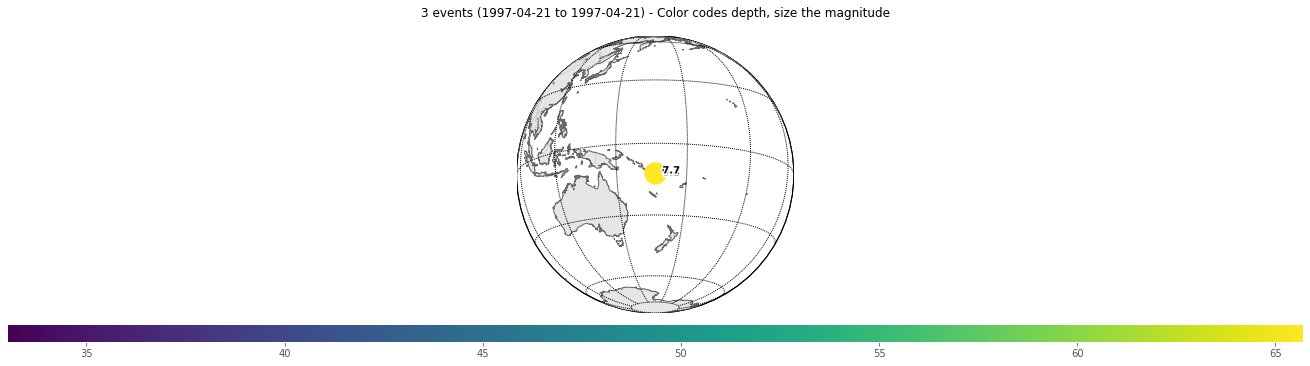

In [18]:
catalog.plot("ortho");

In [19]:
# select the Mw7.7 event, rather than the aftershocks
event = catalog[2]
print("Event:")
print(event.short_str())

print("Event info:")
origin = event.preferred_origin()
#print(origin)

t0 = origin.time
lat = origin.latitude
lon = origin.longitude
dep = origin.depth

print("  time   : ",t0)
print("  lat/lon: ",lat,"/",lon,"(degree)")
print("  depth  : ",dep,"(m)")

# magnitude
magnitude = event.preferred_magnitude()
if magnitude == None:
    M = 0.0
    M_type = "no magnitude information available"
else:
    M = magnitude.mag
    M_type = magnitude.magnitude_type
print("  magnitude: ",M,"type ",M_type)

# moment magnitude
if M_type.lower() == 'mw':
    Mw = M
else:
    Mw = 0.0
    
# seismic moment based on moment magnitude (Kanamori, 1977): Mw = 2/3 log(M0) - 10.7 
M0 = 10**(3/2 * (Mw + 10.7))  # in dyne cm
# converts to (N m)
M0 = M0 * 1.e-7

print("")
print("Moment magnitude: ",Mw)
print("Seismic Moment  : ",M0,"(N m)")
print("")


Event:
1997-04-21T12:02:30.370000Z | -12.600, +166.643 | 7.7 mw
Event info:
  time   :  1997-04-21T12:02:30.370000Z
  lat/lon:  -12.6004 / 166.6428 (degree)
  depth  :  65700.0 (m)
  magnitude:  7.7 type  mw

Moment magnitude:  7.7
Seismic Moment  :  3.981071705534953e+20 (N m)



## 2. Station information

Let's get some information about a station with waveform data.<br>

You can compare these waveforms with the book Figure 2.7-1 from Stein & Wysession, *An Introduction to Seismology, Earthquakes, and Earth Structure*, Blackwell Science, Oxford 2003

In [20]:
print("getting station information...")

# gets station informations
t1 = event_time
t2 = t1 + 10 * 60

# Global network stations (naming starts with A***)
inventory = c.get_stations(network="IU", station="CCM*",
                                starttime=t1,endtime=t2)
print(inventory)

getting station information...
Inventory created at 2020-03-05T07:58:40.000000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.44
		    http://service.iris.edu/fdsnws/station/1/query?starttime=1997-04-21...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			IU
		Stations (1):
			IU.CCM (Cathedral Cave, Missouri, USA)
		Channels (0):



We will look at station CCM (Cathedral Cave, US) from the global seismograph network:<br>
https://earthquake.usgs.gov/monitoring/operations/stations/IU/CCM/<br>


In [21]:
print("inventory: ",len(inventory))
# network
network = inventory[0]
print(network)

# CCM station in the list
station = network[0]
print(station)

# station lat/lon
sta_lat = station.latitude
sta_lon = station.longitude
print("station lat/lon: ",sta_lat,"/",sta_lon)

# event lat/lon
source_lat = event.preferred_origin().latitude
source_lon = event.preferred_origin().longitude
print("event   lat/lon: ",source_lat,"/",source_lon)

# epicentral distance 
def epi_distance(lon1,lat1,lon2,lat2):
    # calculates epicentral distance between 2 lon/lat points (in degrees)
    # converts to radians
    radlon1 = np.radians(lon1); radlat1 = np.radians(lat1)
    radlon2 = np.radians(lon2); radlat2 = np.radians(lat2)
    # Haversine formula
    dlon = radlon2 - radlon1
    dlat = radlat2 - radlat1
    a = np.sin(dlat/2.0)**2 + np.cos(radlat1) * np.cos(radlat2) * np.sin(dlon/2.0)**2
    c = 2.0 * np.arcsin(np.sqrt(a))
    # converts to degrees
    epi = np.degrees(c)
    return epi

dist = epi_distance(source_lon,source_lat,sta_lon,sta_lat)
print("epicentral distance: ",dist,"(deg)")

inventory:  1
Network IU (Global Seismograph Network - IRIS/USGS (GSN))
	Station Count: 1/270 (Selected/Total)
	1988-01-01T00:00:00.000000Z - --
	Access: open
	Contains:
		Stations (1):
			IU.CCM (Cathedral Cave, Missouri, USA)
		Channels (0):

Station CCM (Cathedral Cave, Missouri, USA)
	Station Code: CCM
	Channel Count: 0/47 (Selected/Total)
	1996-06-07T21:00:00.000000Z - 2011-07-14T00:00:00.000000Z
	Access: open 
	Latitude: 38.06, Longitude: -91.24, Elevation: 222.0 m
	Available Channels:

station lat/lon:  38.0557 / -91.2446
event   lat/lon:  -12.6004 / 166.6428
epicentral distance:  107.200697303 (deg)


In [22]:
# seismograms
print("getting waveform...")

# Stations
# station: CCM (Cathedral Cave, Missouri, USA), broadband channel
net = "IU"
sta = "CCM"
cha = "BH*"
loc = "*" 

# time window
tshift_begin = 0 # 0 min earlier
tshift_end = 90 * 60 # 90 min after
t1 = t0 + tshift_begin             
t2 = t0 + tshift_end

# dowloads seismogram as a stream
st = c.get_waveforms(network=net, station=sta, location=loc, channel=cha,
                     starttime=t1,endtime=t2, attach_response=True)
print(st)
print("")


getting waveform...
3 Trace(s) in Stream:
IU.CCM..BHE | 1997-04-21T12:02:30.415000Z - 1997-04-21T13:32:30.365000Z | 20.0 Hz, 108000 samples
IU.CCM..BHN | 1997-04-21T12:02:30.415000Z - 1997-04-21T13:32:30.365000Z | 20.0 Hz, 108000 samples
IU.CCM..BHZ | 1997-04-21T12:02:30.415000Z - 1997-04-21T13:32:30.365000Z | 20.0 Hz, 108000 samples



In [23]:
# trace statistics
tr = st[0]
#print(tr.stats)
npts = tr.stats.npts      # number of samples
dt = tr.stats.delta       # time step
duration = npts * dt

freq_Ny = 1.0/(2.0 * dt)  # Nyquist frequency
freq_min = 1./duration    # minimal possible frequency for length of trace

print("trace:")
print("  duration = ",duration,"s"," = ",duration/60.,"min"," = ",duration/60./60.,"h")
print("  Nyquist frequency = ",freq_Ny)
print("  minimum frequency = ",freq_min)
print("")


trace:
  duration =  5400.0 s  =  90.0 min  =  1.5 h
  Nyquist frequency =  10.0
  minimum frequency =  0.00018518518518518518



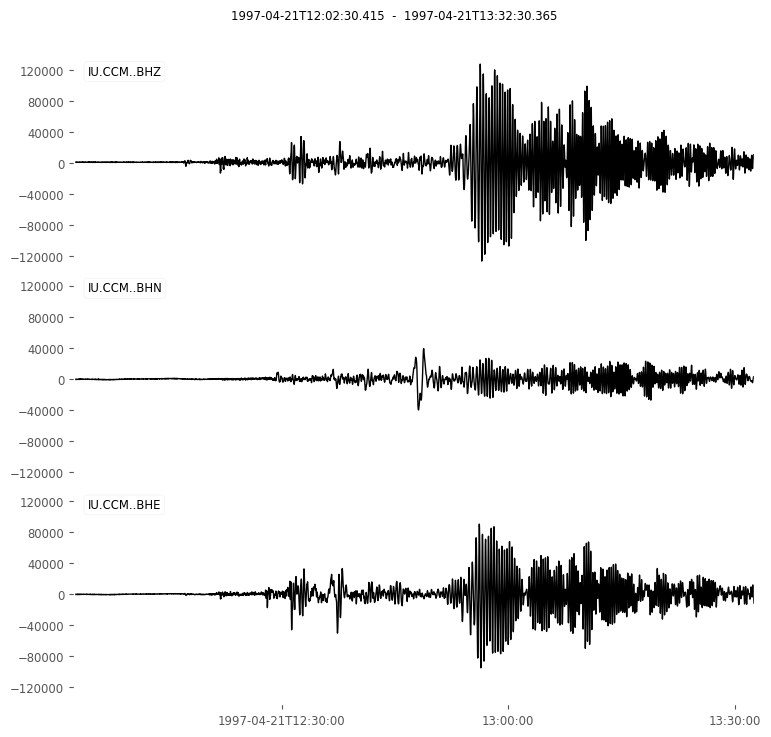

In [24]:
# plotting traces
st.plot();

IU.CCM..BHZ | 1997-04-21T12:02:30.415000Z - 1997-04-21T13:32:30.365000Z | 20.0 Hz, 108000 samples


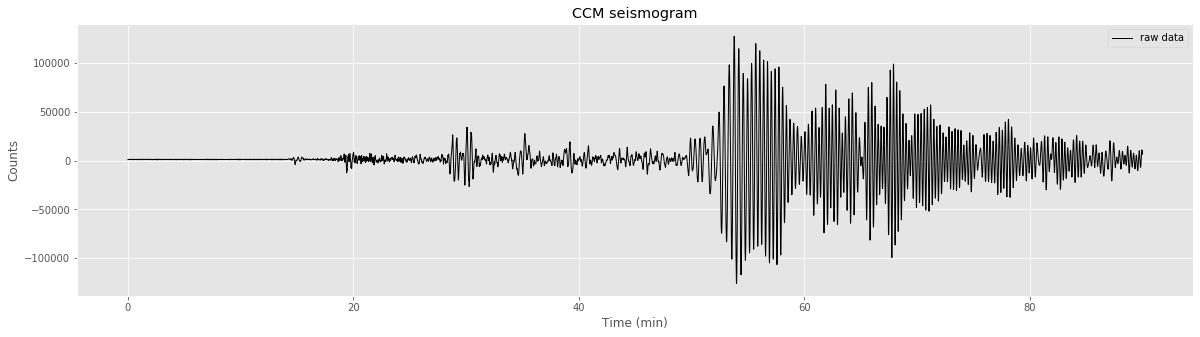

In [25]:
# time axis for plotting (in min)
t_d = np.linspace(0,duration,npts) / (60.0)  
# shift time scale to have 0 at event origin time
t_d += tshift_begin / 60.0

# vertical trace
print(st[2])

# plotting
plt.title("CCM seismogram")
# vertical component
plt.plot(t_d, st[2].data, color='black', linewidth=1.0,label="raw data")
plt.legend()
plt.xlabel("Time (min)")
plt.ylabel("Counts")
plt.show()


## 2. Data processing

Detrending, tapering

processing waveform data...


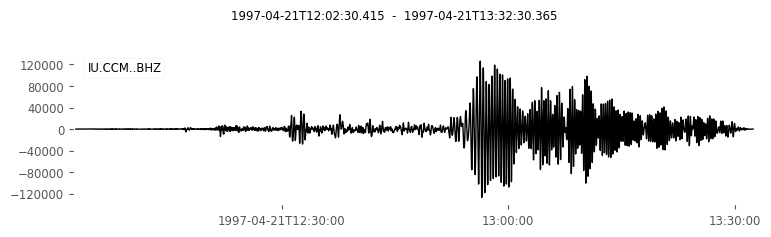

In [26]:
print("processing waveform data...")

# working copy for processing
st_w = st.copy()

# detrending & tapering
st_w.detrend("linear")
st_w.detrend("demean")
st_w.taper(max_percentage=0.05)

# plots new vertical trace
st_w[2].plot();

Converts tick count to ground displacement:

In [27]:
# obspy check, older version 1.1.1 has some issues with newer numpy version > 1.17
# checks numpy fftpack routine
print("numpy version",np.__version__)
print("obspy version",obspy.__version__)

if np.__version__ >= '1.17.0' and obspy.__version__ < '1.2.0':
    # warning
    print("")
    print("*** Please check if instrument removal works with your setup of obspy and numpy version.")
    print("*** ")
    print("*** Upgrading to obspy version 1.2.0 might be a good solution,")
    print("*** or downgrading numpy to a version < 1.17.0 can help as well.")
    print("*** ")
    print("*** In case you run into an error because of a missing fftpack() routine, you could modify the file")
    print("***   <my_python_obspy_path>/obspy/core/trace.py")
    print("***   for example")
    print("***   /opt/local/Library/Frameworks/Python.framwork/Versions/3.7/lib/python3.7/site-packages/obspy/core/trace.py")
    print("*** and replace the line:")
    print("***     #original:")
    print("***     #limit_numpy_fft_cache()")
    print("***     #daniel fix: https://github.com/obspy/obspy/issues/2434 ")
    print("***     if np.__version__ < '1.17.0': limit_numpy_fft_cache() ")
    print("*** which will work just fine.")
    print("")


numpy version 1.18.1
obspy version 1.1.1

*** Please check if instrument removal works with your setup of obspy and numpy version.
*** 
*** Upgrading to obspy version 1.2.0 might be a good solution,
*** or downgrading numpy to a version < 1.17.0 can help as well.
*** 
*** In case you run into an error because of a missing fftpack() routine, you could modify the file
***   <my_python_obspy_path>/obspy/core/trace.py
***   for example
***   /opt/local/Library/Frameworks/Python.framwork/Versions/3.7/lib/python3.7/site-packages/obspy/core/trace.py
*** and replace the line:
***     #original:
***     #limit_numpy_fft_cache()
***     #daniel fix: https://github.com/obspy/obspy/issues/2434 
***     if np.__version__ < '1.17.0': limit_numpy_fft_cache() 
*** which will work just fine.



In [28]:
# instrument response removal
# (unstable procedure)
# frequency range
f1 = 1.0/400.0  # low-frequency taper range (Hz)
f2 = 1.0/200.0  
f3 = 2.0        # high-frequency taper range (Hz)
f4 = 4.0

st_disp = st_w.copy()
st_disp.remove_response(output="DISP",pre_filt=(f1,f2,f3,f4))

print("data converted to displacement:")
print("  vertical displacement min/max = ",st_disp[2].data.min(),"/",st_disp[2].data.max(),"(m)")

data converted to displacement:
  vertical displacement min/max =  -0.000632013868656 / 0.000689250205972 (m)


# 3. Plotting

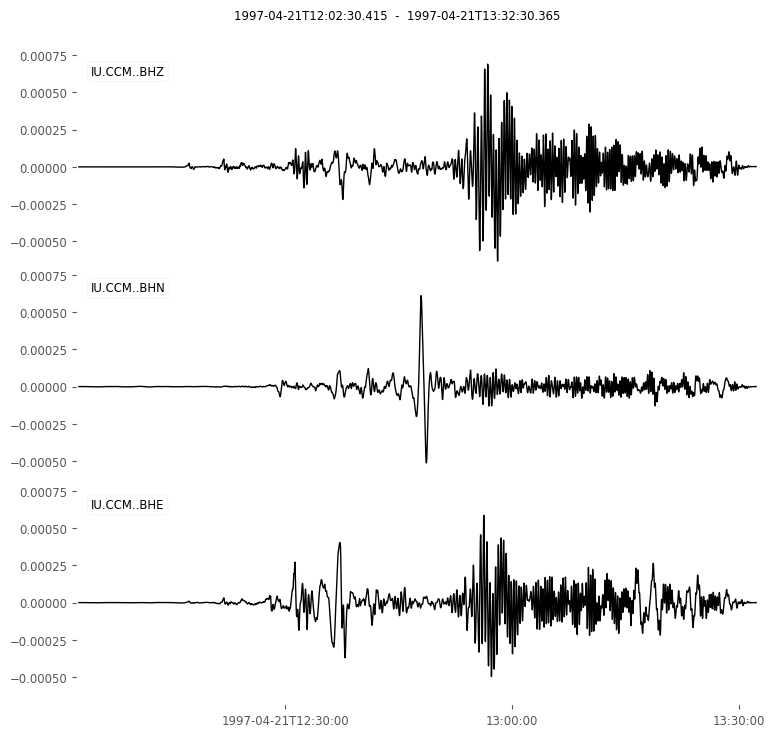

In [29]:
# plots traces
st_disp.plot();

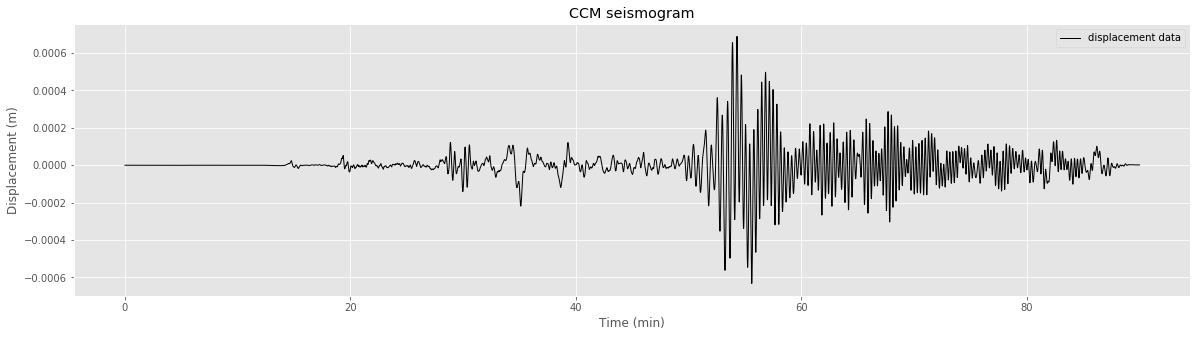

In [30]:
# vertical trace in displacement
tr1 = st_disp[2].copy()

# plotting
plt.title("CCM seismogram")
plt.plot(t_d, tr1, color='black', linewidth=1.0,label="displacement data")
plt.legend()
plt.xlabel("Time (min)")
plt.ylabel("Displacement (m)")
plt.show()

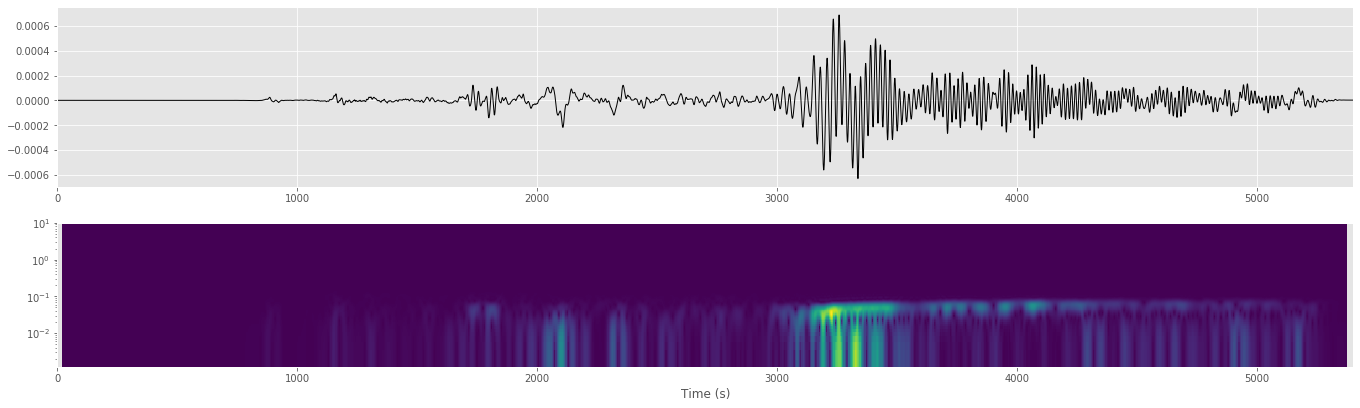

In [31]:
# spectograms
fig = plt.figure();
ax1 = fig.add_axes([0.0, 0.5, 0.9, 0.5]) #[left bottom width height]
ax2 = fig.add_axes([0.0, 0.0, 0.9, 0.4], sharex=ax1) #[left bottom width height]
ax1.set_xlim(0,1200)
# vertical trace in displacement
ax1.plot(t_d*60, st_disp[2].data, color='black', linewidth=1.0,label="ANMO data")
plt.xlabel("Time (s)")

from matplotlib.cm import get_cmap
#cmap_r = get_cmap('gist_earth_r') # inverts plt.cm.gist_earth
cmap_r = get_cmap('viridis')
st_disp[2].spectrogram(axes=ax2, log=True, wlen=40, cmap=cmap_r, show=True);


# 4. Ray paths

Plots simple ray paths for P- and S-waves.
Let's start with getting the epicentral distance from station to the event.

In [32]:
## epicentral distance
# station lat/lon
sta_lat = station.latitude
sta_lon = station.longitude
print("station lat/lon: ",sta_lat,"/",sta_lon)

# event lat/lon
lat = event.preferred_origin().latitude
lon = event.preferred_origin().longitude
print("event   lat/lon: ",lat,"/",lon)

# epicentral distance
from math import pi,sin,cos,asin,sqrt
# converts to radians
lat1_radians = lat * pi/180.0
lon1_radians = lon * pi/180.0
lat2_radians = sta_lat * pi/180.0
lon2_radians = sta_lon * pi/180.0
    
mid_lat = (lat1_radians - lat2_radians)/2.0
mid_lon = (lon1_radians - lon2_radians)/2.0

# Haversine formula    
tmp = sqrt( pow(sin(mid_lat),2) + cos(lat1_radians)*cos(lat2_radians)*pow(sin(mid_lon),2) )
    
distance_radians = 2.0 * asin(tmp)
dist = distance_radians * 180.0/pi
print("epicentral distance :",dist,"(degree)")


station lat/lon:  38.0557 / -91.2446
event   lat/lon:  -12.6004 / 166.6428
epicentral distance : 107.20069730269834 (degree)


Now let calculate and plot rays using the [TauP toolkit](https://www.seis.sc.edu/taup/) calculator implemented in obspy.

In [33]:
# rays using TauP
from obspy.taup import TauPyModel
# models: prem, iasp91, ak135f
model = TauPyModel(model="prem")

# event depth
dep_km = event.preferred_origin().depth / 1000.0 # in km

print("tauP:")
print("  distance: ",dist)
print("  depth   : ",dep_km,"(km)")



tauP:
  distance:  107.20069730269834
  depth   :  65.7 (km)


4 arrivals
	Pdiff phase arrival at 848.215 seconds
	PP phase arrival at 1115.657 seconds
	SKS phase arrival at 1483.439 seconds
	SS phase arrival at 2021.214 seconds


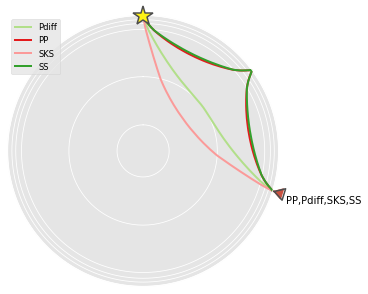

In [34]:
# since we have multiple arrivals, let's focus on the first ones
# only P-wave arrivals
arrivals_P = model.get_ray_paths(source_depth_in_km=dep_km, distance_in_degree=dist, phase_list=["Pdiff","PP"])
#print(arrivals_P)

# only S-wave arrivals
arrivals_S = model.get_ray_paths(source_depth_in_km=dep_km, distance_in_degree=dist, phase_list=["SKS","SS"])
#print(arrivals_S)

# plots only first P & S rays
arrivals = obspy.taup.tau.Arrivals([],model=model.model)
for arr in arrivals_P:
    arrivals.append(arr)
for arr in arrivals_S:
    arrivals.append(arr)

print(arrivals)
ax = arrivals.plot_rays(plot_type="spherical",label_arrivals=True,legend=True)



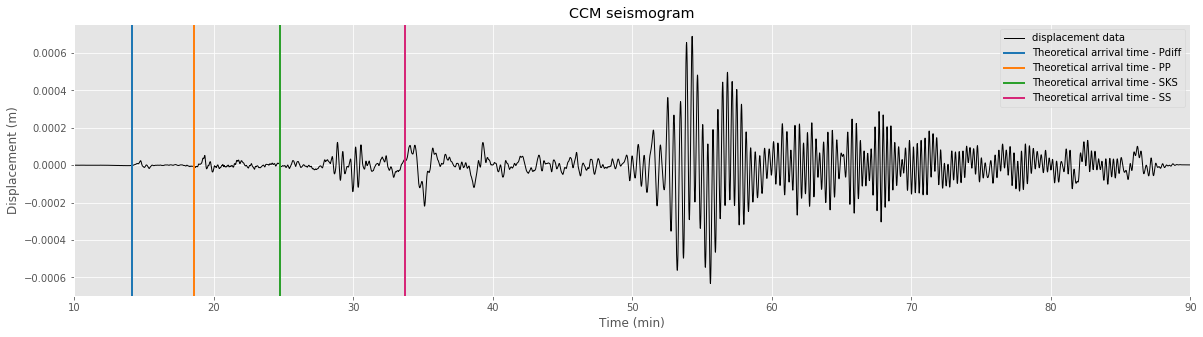

In [37]:
# plotting
plt.xlim(10.0, 90.0)
plt.title("CCM seismogram")
plt.plot(t_d, tr1, color='black', linewidth=1.0,label="displacement data")

# plot arrival times
for i,a in enumerate(arrivals):
    t_a = a.time / 60.0 # in min
    name = a.name
    colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62778','#17becf']
    c = colors[i%5]
    plt.axvline(t_a, color=c, linewidth=2.0, label="Theoretical arrival time - {}".format(name)) 
plt.legend(loc='upper right')

plt.xlabel("Time (min)")
plt.ylabel("Displacement (m)")
plt.show()


# 5. Component rotations

To separate surface waves, it also helps to rotate the horizontal station components from North/East to a Radial/Transverse directions.

In [38]:
# get back-azimuth
print(st_disp)

# back-azimuth
from obspy.clients.iris import Client
c = Client() 
# back-azimuth using the WGS84 spheroid to correct for ellipticity
result = c.distaz(stalat=sta_lat, stalon=sta_lon, evtlat=source_lat,evtlon=source_lon)
ba = result['backazimuth']

# epicentral distance
dist = epi_distance(source_lon,source_lat,sta_lon,sta_lat)
print("epicentral distance: ",dist,"(deg)")

# azimuth/back-azimuth formula
from math import atan2,sin,cos,pi
epi = dist * pi/180.0
lat1 = source_lat * pi/180.0
lon1 = source_lon * pi/180.0
lat2 = sta_lat * pi/180.0
lon2 = sta_lon * pi/180.0
# azimuth
azi = atan2( cos(lat2)*cos(lat1)*sin(lon2-lon1), sin(lat1)-cos(epi)*sin(lat2) )
azi = azi * 180.0/pi
if azi < 0.0: azi += 360.0
if azi > 360.0: azi -= 360.0
# back-azimuth
bazi = atan2( cos(lat2)*cos(lat1)*sin(lon1-lon2), sin(lat1)-cos(epi)*sin(lat2) )
bazi = bazi * 180.0/pi
if bazi < 0.0: bazi += 360.0
if bazi > 360.0: bazi -= 360.0

print("")
print("station lat/lon: ",sta_lat,sta_lon)
print("event   lat/lon: ",source_lat,source_lon)
print("back-azimuth: ","{:6.2f} (deg) WGS84 ellipticity-corrected".format(np.float(ba)))
print("back-azimuth: ","{:6.2f} (deg) spherical".format(np.float(bazi)))
print("azimuth     : ","{:6.2f} (deg) spherical".format(np.float(azi)))
print("")

st_rtz = st_disp.copy()
st_rtz.rotate('NE->RT',back_azimuth=ba);


3 Trace(s) in Stream:
IU.CCM..BHE | 1997-04-21T12:02:30.415000Z - 1997-04-21T13:32:30.365000Z | 20.0 Hz, 108000 samples
IU.CCM..BHN | 1997-04-21T12:02:30.415000Z - 1997-04-21T13:32:30.365000Z | 20.0 Hz, 108000 samples
IU.CCM..BHZ | 1997-04-21T12:02:30.415000Z - 1997-04-21T13:32:30.365000Z | 20.0 Hz, 108000 samples
epicentral distance:  107.200697303 (deg)

station lat/lon:  38.0557 -91.2446
event   lat/lon:  -12.6004 166.6428
back-azimuth:  267.44 (deg) WGS84 ellipticity-corrected
back-azimuth:  267.27 (deg) spherical
azimuth     :   92.73 (deg) spherical



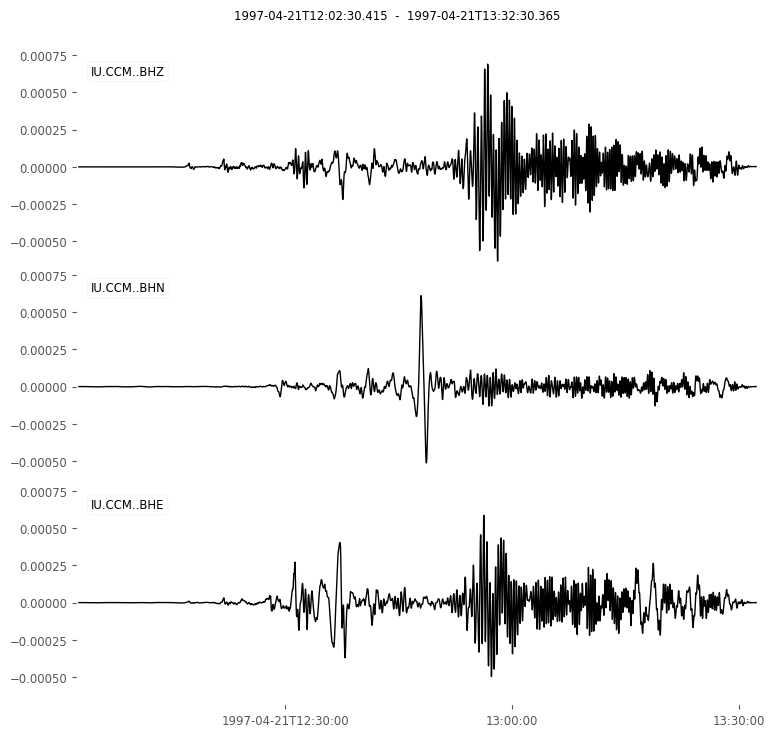

In [39]:
# original N-E-Z
st_disp.plot();

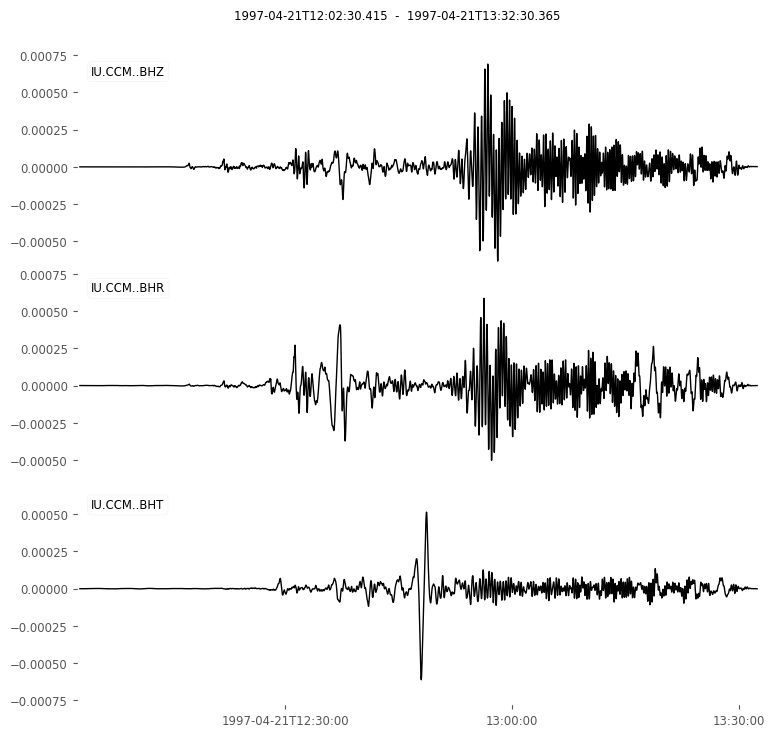

In [40]:
# rotated R-T-Z
st_rtz.plot();

3 Trace(s) in Stream:
IU.CCM..BHT | 1997-04-21T12:02:30.415000Z - 1997-04-21T13:32:30.365000Z | 20.0 Hz, 108000 samples
IU.CCM..BHR | 1997-04-21T12:02:30.415000Z - 1997-04-21T13:32:30.365000Z | 20.0 Hz, 108000 samples
IU.CCM..BHZ | 1997-04-21T12:02:30.415000Z - 1997-04-21T13:32:30.365000Z | 20.0 Hz, 108000 samples


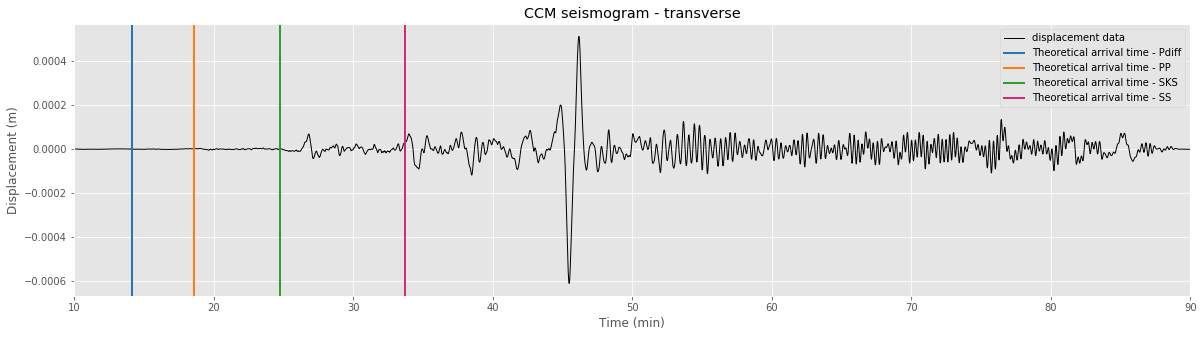

In [42]:
print(st_rtz)

# plotting transverse component
plt.xlim(10.0, 90.0)
plt.title("CCM seismogram - transverse")
plt.plot(t_d, st_rtz[0], color='black', linewidth=1.0,label="displacement data")

# plot arrival times
for i,a in enumerate(arrivals):
    t_a = a.time / 60.0 # in min
    name = a.name
    colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62778','#17becf']
    c = colors[i%5]
    plt.axvline(t_a, color=c, linewidth=2.0, label="Theoretical arrival time - {}".format(name)) 
plt.legend(loc='upper right')

plt.xlabel("Time (min)")
plt.ylabel("Displacement (m)")
plt.show()



Now, separate Love and Rayleigh waves and look at their amplitude spectra compared to body waves.

# 6. Amplitude spectra

First, let us separate body and surface waves based on the rotated components and time windows around the signals.

In [43]:
# body waves
t_body_1 = 25 * 60 # (s) start time 13 min after event origin time
t_body_2 = 32 * 60 # end time

# Love waves
t_L_1 = 43 * 60 # (s) start time 43 min
t_L_2 = 50 * 60 

# Rayleigh waves
t_R_1 = 50 * 60 # (s) start time 50 min
t_R_2 = 57 * 60

# traces start time
t0 = st_rtz[0].stats.starttime

# trace on tranverse component
st_L = st_rtz[0].copy()
# trace on vertical component
st_R = st_rtz[2].copy()
# trace on vertical component
st_body = st_rtz[2].copy()

# trim signals
st_L.trim(t0 + t_L_1, t0 + t_L_2)     
st_R.trim(t0 + t_R_1, t0 + t_R_2)     
st_body.trim(t0 + t_body_1, t0 + t_body_2)     

# taper signals (using a Hann taper, and 0.05 percentage)
st_L.taper(max_percentage=0.05, type='hann')
st_R.taper(max_percentage=0.05, type='hann')
st_body.taper(max_percentage=0.05, type='hann')

# trace data
tr_L = st_L.data.copy()
tr_R = st_R.data.copy()
tr_body = st_body.data.copy()

print("body wave     min/max: ",tr_body.min(),tr_body.max())
print("Love wave     min/max: ",tr_L.min(),tr_L.max())
print("Rayleigh wave min/max: ",tr_R.min(),tr_R.max())

max_all = max(abs(tr_body.min()),tr_body.max(),abs(tr_L.min()),tr_L.max(),abs(tr_R.min()),tr_R.max())
print("absolut maximum value = ",max_all)


body wave     min/max:  -0.000141079408447 0.000122407120051
Love wave     min/max:  -0.000611084008655 0.000513058568234
Rayleigh wave min/max:  -0.000632013868656 0.000689250205972
absolut maximum value =  0.000689250205972


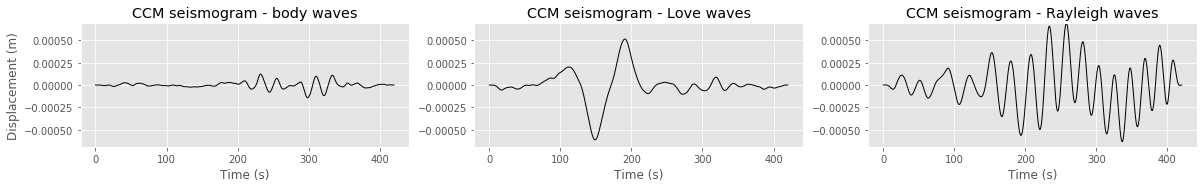

In [44]:
# plotting transverse component
# time axis
t_L = np.linspace(0,st_L.stats.npts*st_L.stats.delta,st_L.stats.npts)
t_R = np.linspace(0,st_R.stats.npts*st_R.stats.delta,st_R.stats.npts)
t_b = np.linspace(0,st_body.stats.npts*st_body.stats.delta,st_body.stats.npts)

# figure
fig = plt.figure()
plt.subplot(2, 3, 1)
plt.title("CCM seismogram - body waves")
plt.plot(t_b, tr_body, color='black', linewidth=1.0,label="displacement data")
plt.ylim(-max_all,max_all)
plt.xlabel("Time (s)")
plt.ylabel("Displacement (m)")
plt.subplot(2, 3, 2)
plt.title("CCM seismogram - Love waves")
plt.plot(t_L, tr_L, color='black', linewidth=1.0,label="displacement data")
plt.ylim(-max_all,max_all)
plt.xlabel("Time (s)")
plt.subplot(2, 3, 3)
plt.title("CCM seismogram - Rayleigh waves")
plt.plot(t_R, tr_R, color='black', linewidth=1.0,label="displacement data")
plt.ylim(-max_all,max_all)
plt.xlabel("Time (s)")
plt.show()

In [45]:
# amplitude spectra
from obspy.signal.freqattributes import spectrum,central_frequency

# takes amplitude spectrum
nf = 65536

dur = st_L.stats.npts*st_L.stats.delta
print("signal Love    : length = ",len(tr_L),"duration = ",dur,"(s) delta = ",st_L.stats.delta)
fc = central_frequency(tr_L,fs=1.0/st_L.stats.delta,smoothie=1.0,fk=1.0)
print("signal Love    : central frequency = ",fc,"(Hz) period = ",1.0/fc,"(s)")

w = np.ones(len(tr_L))
spec_L = spectrum(tr_L,win=w,nfft=nf)

# test with a 5Hz and 8Hz signal
#x = np.linspace(0.0, dur,st_L.stats.npts)
#y = np.sin(5.0 * 2.0*np.pi*x) + 0.5*np.sin(8.0 * 2.0*np.pi*x)
#spec_L = spectrum(y,win=w,nfft=nf)

xf = np.linspace(0.0, 1.0/(2.0*st_L.stats.delta), int(nf/2))

dur = st_R.stats.npts*st_R.stats.delta
print("signal Rayleigh: length = ",len(tr_R),"duration = ",dur,"(s)")
fc = central_frequency(tr_R,fs=1.0/st_R.stats.delta,smoothie=1.0,fk=1.0)
print("signal Rayleigh: central frequency = ",fc,"(Hz) period = ",1.0/fc,"(s)")

w = np.ones(len(tr_R))
spec_R = spectrum(tr_R,win=w,nfft=nf)

dur = st_body.stats.npts*st_body.stats.delta
print("signal body    : length = ",len(tr_body),"duration = ",dur,"(s)")
fc = central_frequency(tr_body,fs=1.0/st_body.stats.delta,smoothie=1.0,fk=1.0)
print("signal body    : central frequency = ",fc,"(Hz) period = ",1.0/fc,"(s)")

w = np.ones(len(tr_body))
spec_body = spectrum(tr_body,win=w,nfft=nf)


signal Love    : length =  8401 duration =  420.05 (s) delta =  0.05
signal Love    : central frequency =  0.0132176206445 (Hz) period =  75.65658199 (s)
signal Rayleigh: length =  8401 duration =  420.05 (s)
signal Rayleigh: central frequency =  0.0358073322638 (Hz) period =  27.9272410643 (s)
signal body    : length =  8401 duration =  420.05 (s)
signal body    : central frequency =  0.0403592129461 (Hz) period =  24.7774901194 (s)


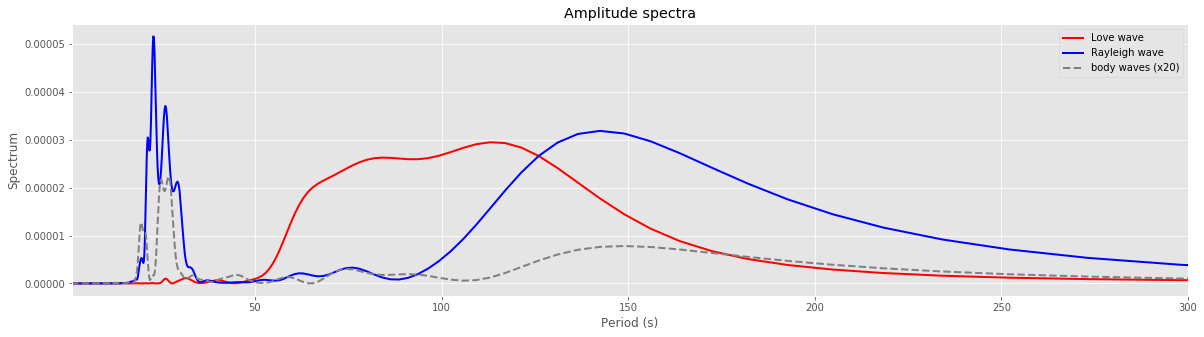

In [47]:
#plotting
fig = plt.figure()
plt.xlim(1.0,300.0)
plt.title("Amplitude spectra")
plt.xlabel("Period (s)")
plt.ylabel("Spectrum")
plt.plot(1.0/xf, spec_L[0:int(nf/2)], color='red', linewidth=2.0,label="Love wave")
plt.plot(1.0/xf, spec_R[0:int(nf/2)], color='blue', linewidth=2.0,label="Rayleigh wave")
plt.plot(1.0/xf, 20*spec_body[0:int(nf/2)], color='gray', linewidth=2.0,linestyle='--',label="body waves (x20)")
plt.legend()
plt.show();

Finally, we do see stronger high-frequency signals for body waves, but the distinctions are not that clear. Also, the long-period surface wave signals look a bit strange and might be affected by motions other than coming from the earthquake. 

Try to find a better source-station pair to separate body-wave and surface-wave signals in a frequency domain. How would you explain the differences in frequency contents?
